# Recommendation Systems Evolutionary Dynamics

## Imports

In [1]:
from recommendation_systems_evolutionary_dynamics import EGT
import numpy as np
import matplotlib.pylab as plt

## Initialize Game
1. Strategies counts for each populations (imiplicitly defining populations sizes)
2. actions names
3. players names
4. payoff matrix

In [2]:
strategies_counts = [[25, 25], [25, 25], [25, 25]]
actions_names = [["Low", "High"], ["Low", "High"], ["Low", "High"]]
players_names = ["Consumer", "Platform", "Provider"]
actions_symbols = ["L", "H"]

s = 0.1
dl = 0.2
dh = 0.1
ul = 0.1
uh = 0.2
a = 0.2
cl = 0.1
ch = 0.2
# Consumer: s = ul = dh < dl = uh
# Platform: a = r < ps
# Provider: cl < ch = a < sp < ps

payoff_matrix_basis = {(0, 0, 0): [s+dl+ul, a, -cl+a],
                       (0, 0, 1): [0, 0, -ch],
                       (0, 1, 0): [0, 0, -cl],
                       (0, 1, 1): [0, 0, -ch],
                       (1, 0, 0): [0, 0, -cl],
                       (1, 0, 1): [0, 0, -ch],
                       (1, 1, 0): [0, 0, -cl],
                       (1, 1, 1): [s+dh+uh, a, -ch+a]}

sp = 0.2
payoff_matrix_sponsers = {(0, 0, 0): [s+dl+ul, a, -cl+a],
                          (0, 0, 1): [0, 0, -ch],
                          (0, 1, 0): [0, 0, -cl],
                          (0, 1, 1): [0, 0, -ch],
                          (1, 0, 0): [0, 0, -cl],
                          (1, 0, 1): [0, 0, -ch],
                          (1, 1, 0): [0, 0, -cl],
                          (1, 1, 1): [s+dh+dl, a, -ch+a+sp]}

r = 0.2
payoff_matrix_reputation = {(0, 0, 0): [s+dl+ul, a, -cl+a],
                            (0, 0, 1): [0, 0, -ch],
                            (0, 1, 0): [0, 0, -cl],
                            (0, 1, 1): [0, r, -ch],
                            (1, 0, 0): [0, 0, -cl],
                            (1, 0, 1): [0, 0, -ch],
                            (1, 1, 0): [0, r, -cl],
                            (1, 1, 1): [s+dh+dl, a+2*r, -ch+a+sp]}

ps = 0.4
payoff_matrix_platform_support = {(0, 0, 0): [s+dl+ul, a, -cl+a],
                            (0, 0, 1): [0, -ps, -ch+ps],
                            (0, 1, 0): [0, 0, -cl],
                            (0, 1, 1): [0, r-ps, -ch+ps],
                            (1, 0, 0): [0, 0, -cl],
                            (1, 0, 1): [0, -ps, -ch+ps],
                            (1, 1, 0): [0, r, -cl],
                            (1, 1, 1): [s+dh+dl, a+2*r-ps, -ch+a+sp+ps]}

payoff_matrix_platform_support_no_rep = {(0, 0, 0): [s+dl+ul, a, -cl+a],
                            (0, 0, 1): [0, -ps, -ch+ps],
                            (0, 1, 0): [0, 0, -cl],
                            (0, 1, 1): [0, -ps, -ch+ps],
                            (1, 0, 0): [0, 0, -cl],
                            (1, 0, 1): [0, -ps, -ch+ps],
                            (1, 1, 0): [0, 0, -cl],
                            (1, 1, 1): [s+dh+dl, a-ps, -ch+a+sp+ps]}

payoff_matrix = payoff_matrix_platform_support_no_rep

game = EGT.Game(strategies_counts=strategies_counts, payoff_matrix=payoff_matrix, actions_names=actions_names, players_names=players_names)

Ps = game.get_populations()
for i, P in enumerate(Ps):
    print(f"P{i}: {np.unique_counts(P)}")
print(game.get_payoff_matrix())

[[0, 1], [0, 1], [0, 1]]
[['Low', 'High'], ['Low', 'High'], ['Low', 'High']] [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]
P0: UniqueCountsResult(values=array([0, 1]), counts=array([25, 25]))
P1: UniqueCountsResult(values=array([0, 1]), counts=array([25, 25]))
P2: UniqueCountsResult(values=array([0, 1]), counts=array([25, 25]))
{(0, 0, 0): [0.4, 0.2, 0.1], (0, 0, 1): [0, -0.4, 0.2], (0, 1, 0): [0, 0, -0.1], (0, 1, 1): [0, -0.4, 0.2], (1, 0, 0): [0, 0, -0.1], (1, 0, 1): [0, -0.4, 0.2], (1, 1, 0): [0, 0, -0.1], (1, 1, 1): [0.4, -0.2, 0.6000000000000001]}


## Evolutionary Dynamics (Finite Populations)

### Moran Process

#### Birth_Death Async

In [3]:
steps = 400
rep = 20

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "bd", sync=False, reps=rep, steps=steps, beta=2.5, mu=0.02, return_hist=True, print_rep_interval=rep//5)

[(20, 401, 2), (20, 401, 2), (20, 401, 2)]
Replicate: 4
Replicate: 8
Replicate: 12
Replicate: 16


##### Evolution Visualization

In [ ]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction", title=f"{actions_names[action]} Strategy Evolution (Birth-Death Async)")

##### Stationary Distribution

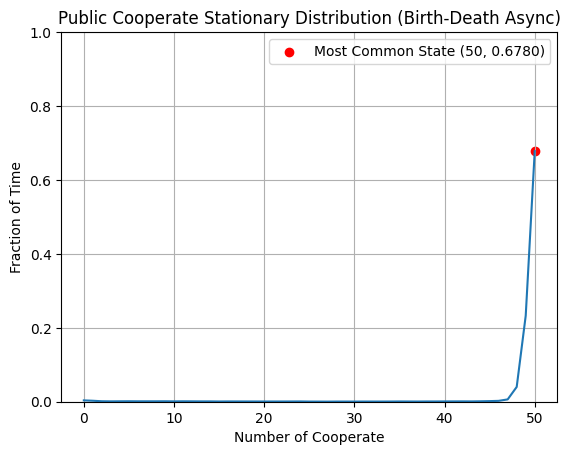

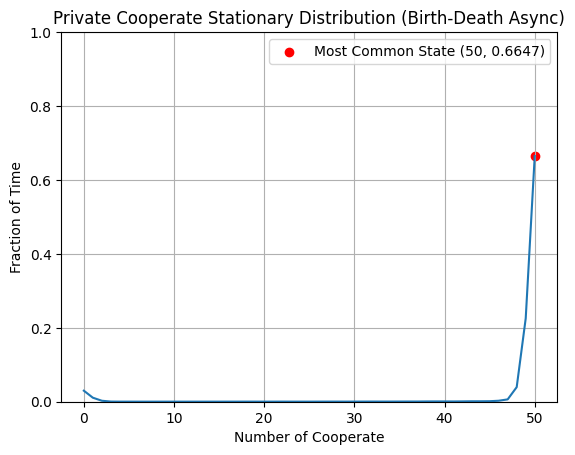

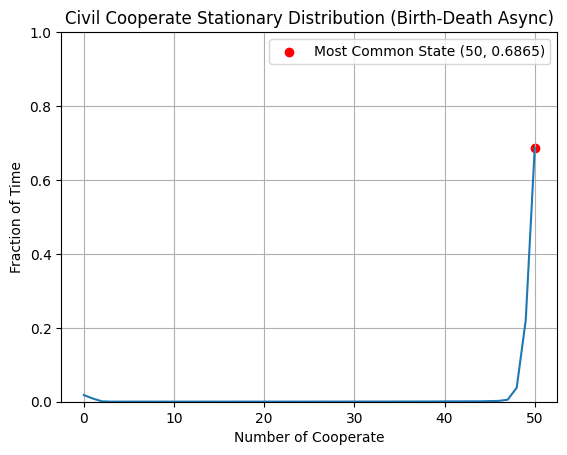

In [15]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution (Birth-Death Async)")

#### Birth_Death Sync

In [94]:
steps = 400
rep = 20

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "bd", sync=True, reps=rep, steps=steps, beta=2.5, mu=0.02, return_hist=True, print_rep_interval=rep//5)

Replicate: 10
Replicate: 20
Replicate: 30
Replicate: 40


##### Evolution Visualization

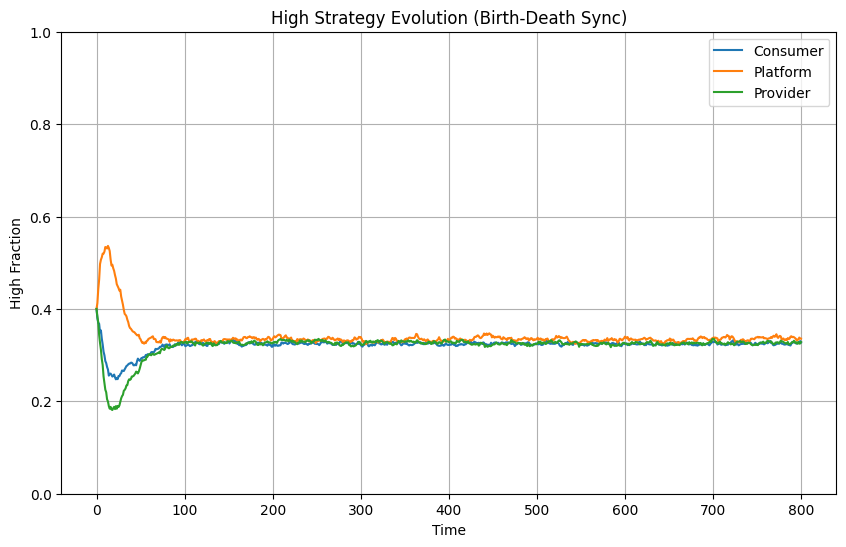

In [95]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction" , title=f"{actions_names[action]} Strategy Evolution (Birth-Death Sync)")

##### Stationary Distribution

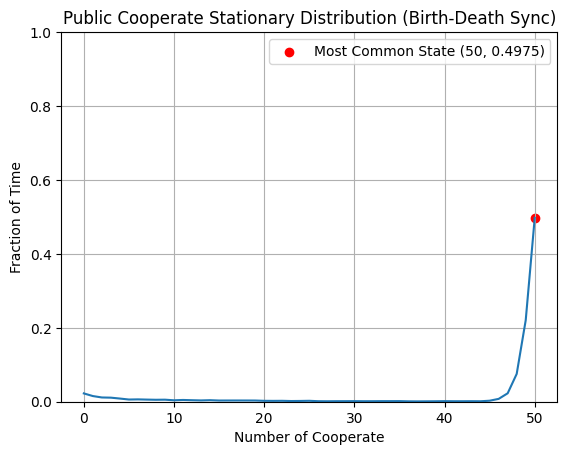

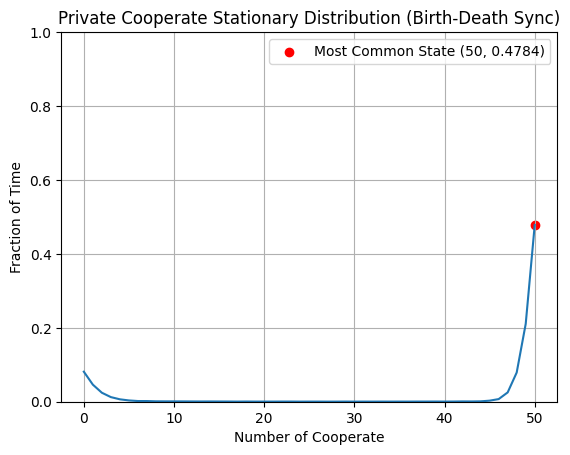

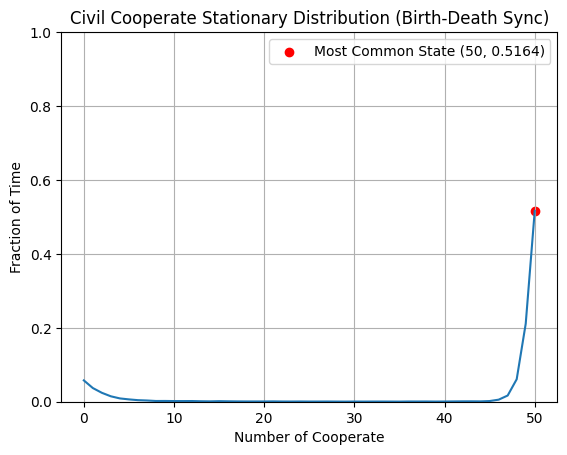

In [18]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution (Birth-Death Sync)")

#### Death-Birth Async

In [19]:
steps = 10000
rep = 50

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "db", sync=False, reps=rep, steps=steps, beta=2.5, mu=0.02, return_hist=True, print_rep_interval=rep//5)

Replicate: 10
Replicate: 20
Replicate: 30
Replicate: 40


##### Evolution Visualization

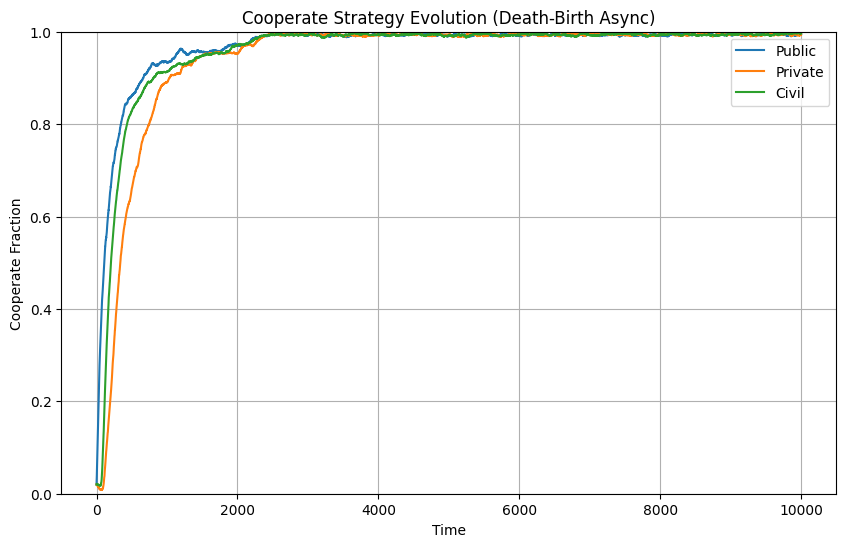

In [20]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction", title=f"{actions_names[action]} Strategy Evolution (Death-Birth Async)")

##### Stationary Distribution

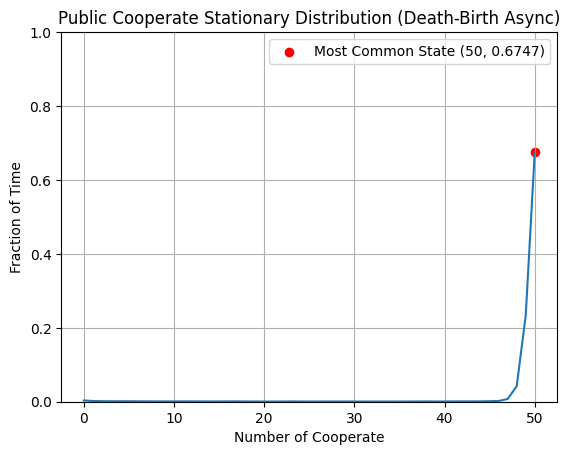

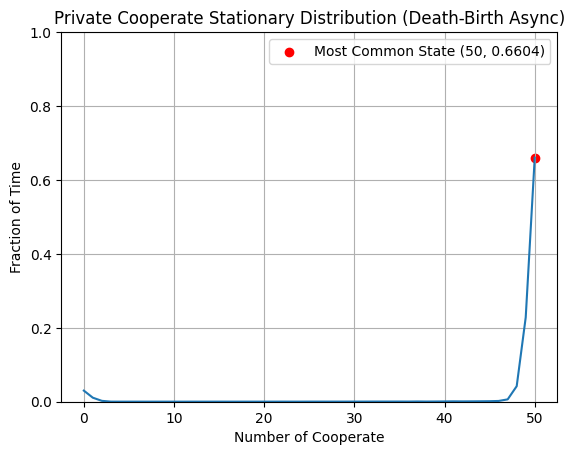

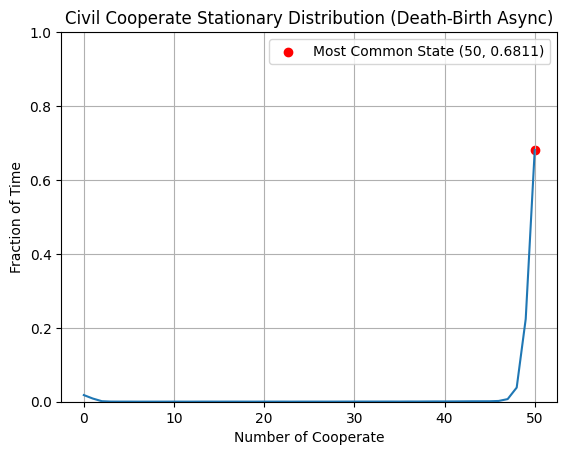

In [21]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution (Death-Birth Async)")

#### Death-Birth Sync

In [22]:
steps = 800
rep = 50

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "db", sync=True, reps=rep, steps=steps, beta=2.5, mu=0.02, return_hist=True, print_rep_interval=rep//5)

Replicate: 10
Replicate: 20
Replicate: 30
Replicate: 40


##### Evolution Visualization

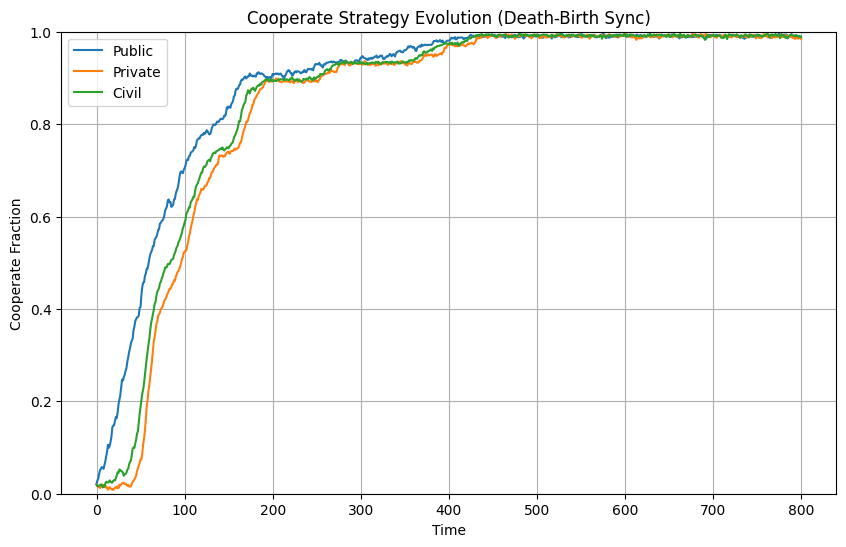

In [23]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction", title=f"{actions_names[action]} Strategy Evolution (Death-Birth Sync)")

##### Stationary Distribution

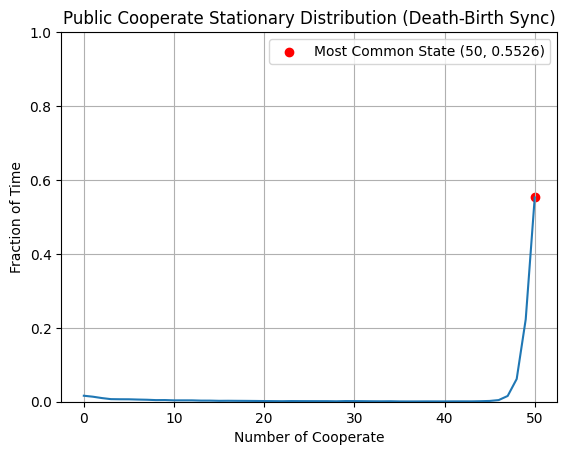

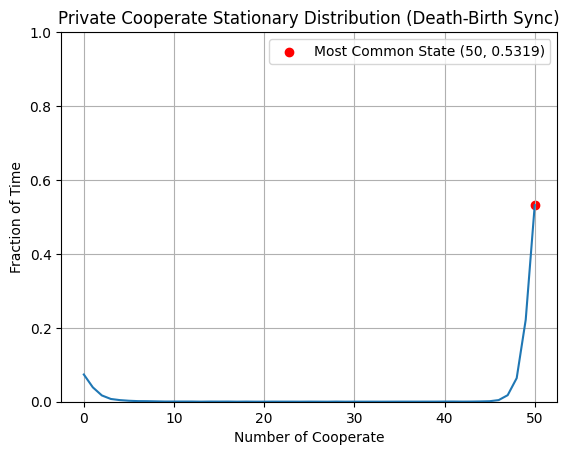

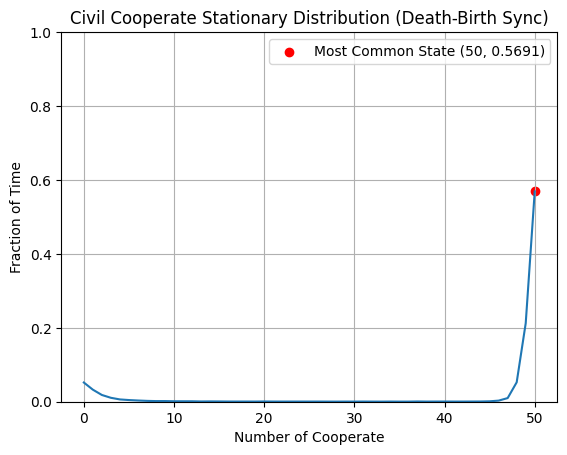

In [24]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution (Death-Birth Sync)")

#### Pairwise Async

In [194]:
steps = 2000
rep = 40

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "pairwise", sync=False, reps=rep, steps=steps, beta=2.5, mu=0.02, return_hist=True, print_rep_interval=rep//5)

Replicate: 8
Replicate: 16
Replicate: 24
Replicate: 32


##### Evolution Visualization

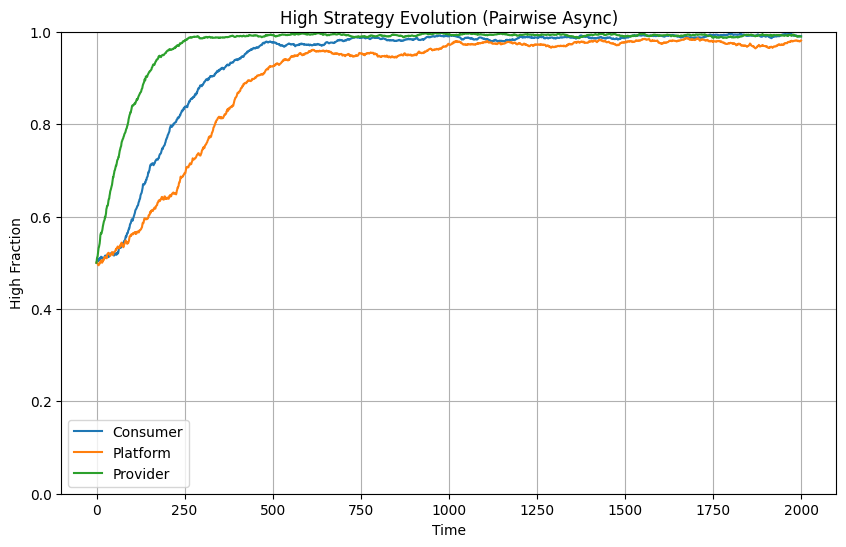

In [195]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction", title=f"{actions_names[action]} Strategy Evolution (Pairwise Async)")

##### Stationary Distribution

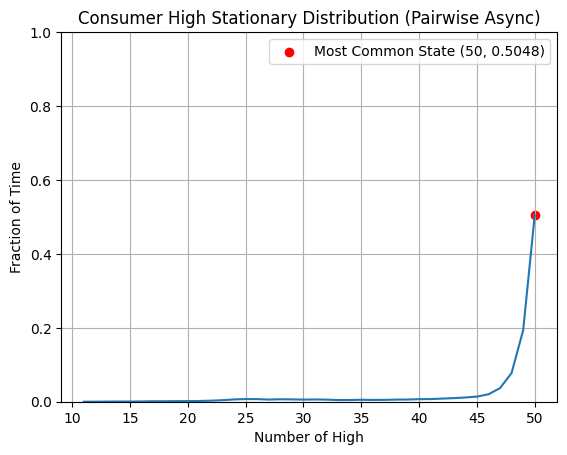

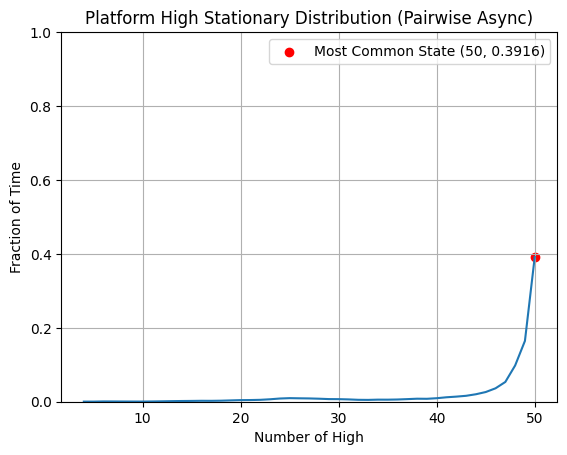

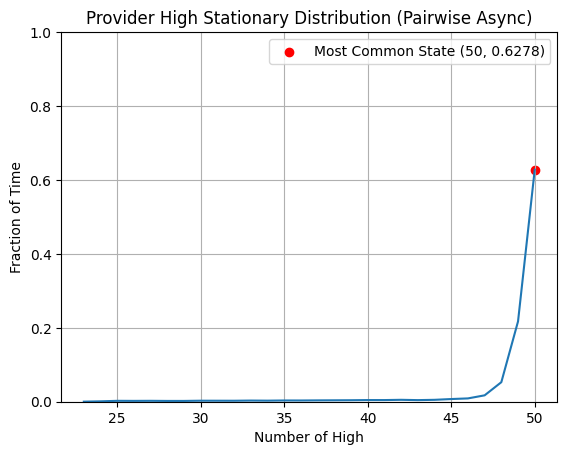

In [196]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution (Pairwise Async)")

#### Pairwise Sync

In [32]:
steps = 400
rep = 50

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "pairwise", sync=True, reps=rep, steps=steps, beta=2.5, mu=0.02, return_hist=True, print_rep_interval=rep//5)


KeyboardInterrupt



##### Evolution Visualization

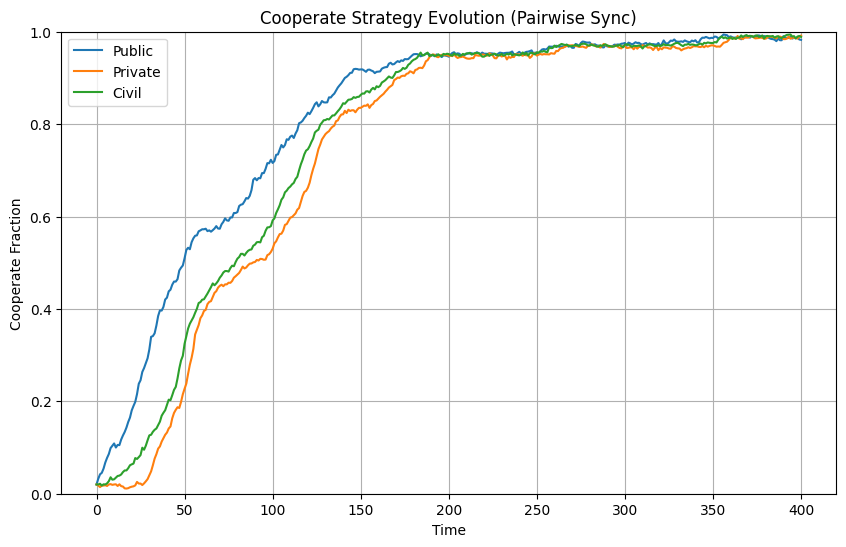

In [29]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction", title=f"{actions_names[action]} Strategy Evolution (Pairwise Sync)")

##### Stationary Distribution

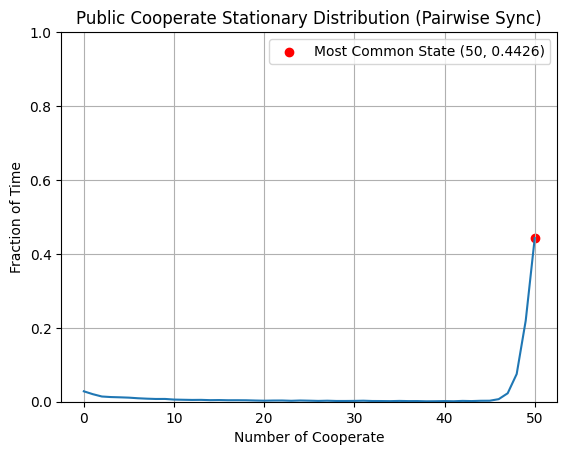

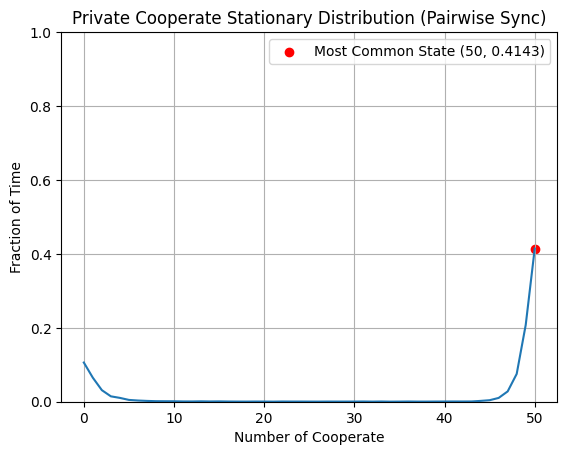

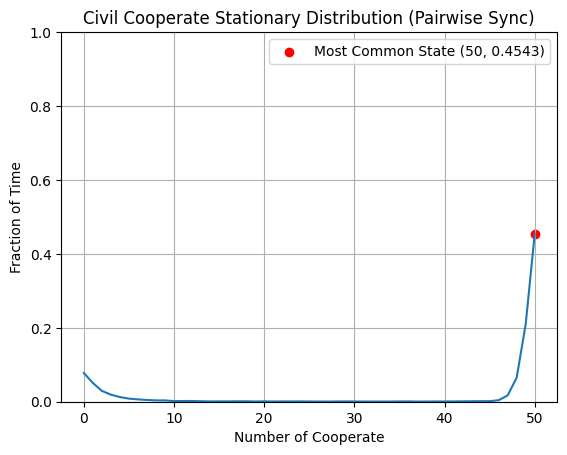

In [30]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution (Pairwise Sync)")

### Transition Matrix (Embedded Markov Chain)

In [197]:
matrix, states = game.compute_trans_matrix(beta=0.08)
matrix[1][0], matrix[1][3]

0
1
2
3
4
5
6
7


(np.float64(0.0054437319792968895), np.float64(0.006666666666666667))

#### Embedded Markov Chain Visualization

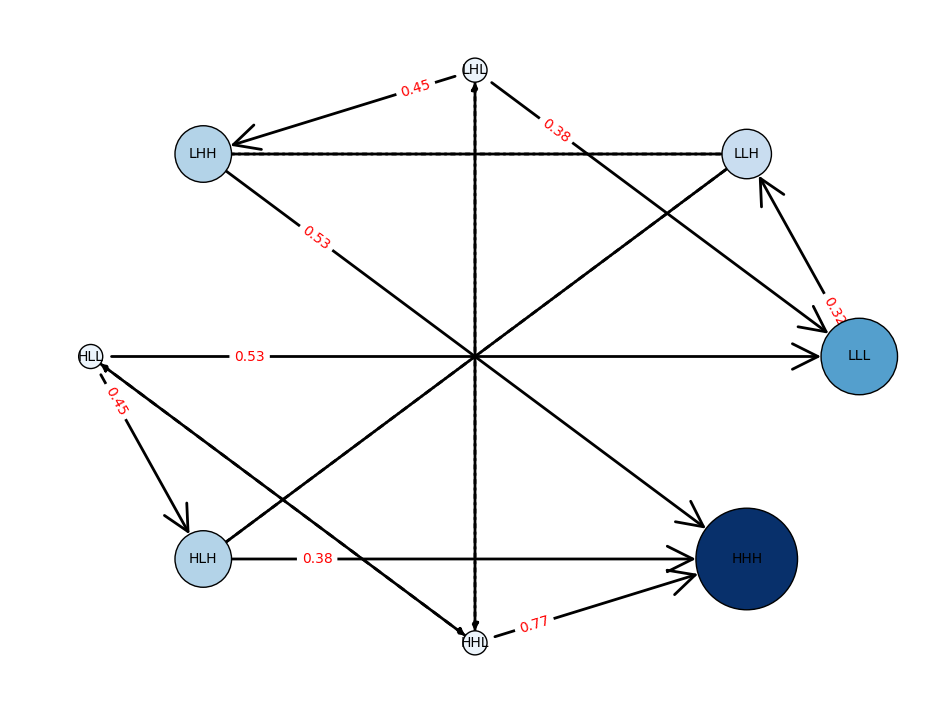

In [198]:
game.plot_transition_matrix(matrix, states=states, actions_symbols=actions_symbols, scale=40)

##### Most probable route given a starting state and an ending state

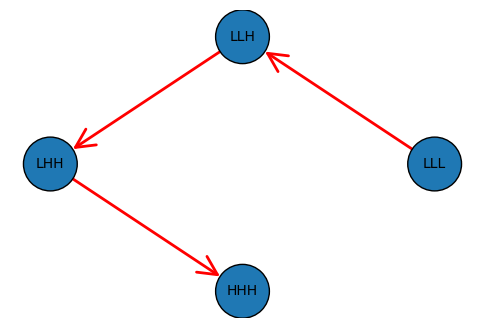

In [199]:
start_state = (0,0,0)
end_state = (1,1,1)
game.plot_transition_matrix_most_probable_route_from_i_to_j(matrix, states, actions_symbols, start_state, end_state, scale=40)

##### Most probable route given a starting state

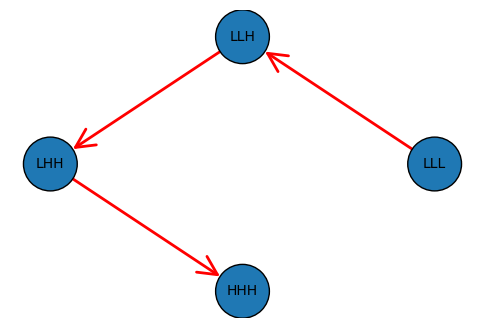

In [200]:
start_state = (0,0,0)
game.plot_transition_matrix_most_probable_route_from_i(matrix, states, actions_symbols, start_state, scale=40)

#### Stationary distrtibution from Transition Matrix 

In [201]:
stationary_distribution = game.compute_stationary_distribution(matrix)
stationary_distribution

array([0.17627077, 0.12419712, 0.08347001, 0.07841071, 0.06542347,
       0.10961662, 0.07989277, 0.28271852])

##### Visualize Stationary Distributions

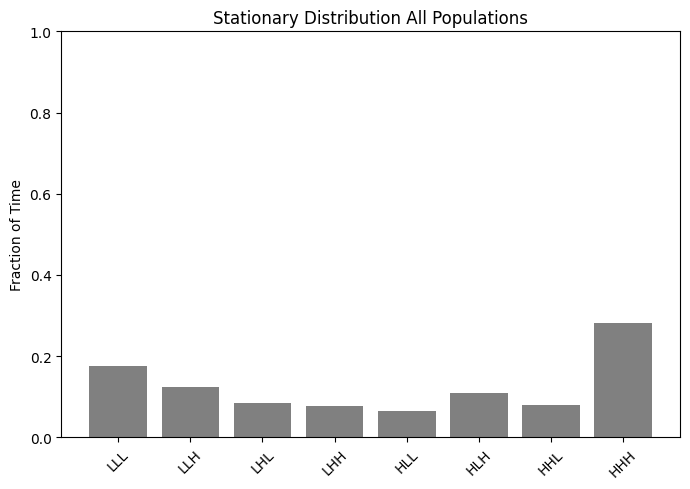

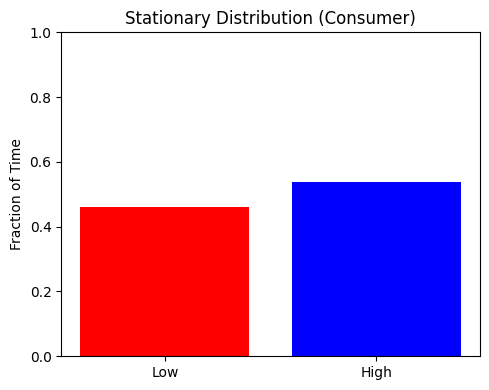

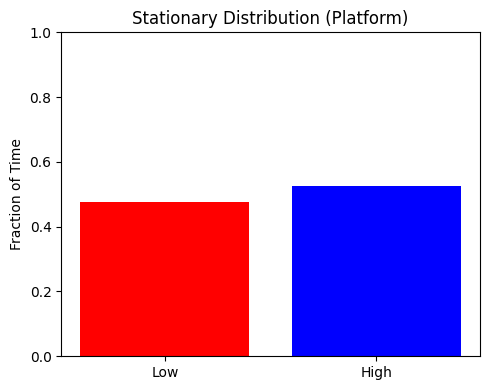

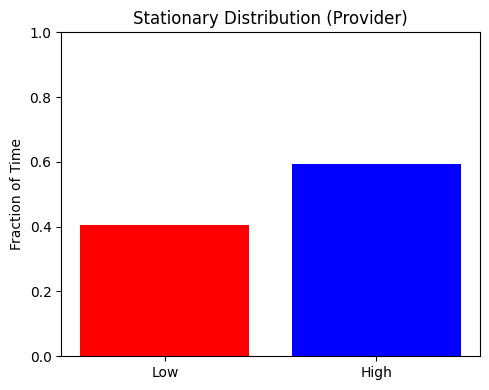

In [202]:
game.plot_stationary_distribution_all_pop(stationary_distribution, actions_symbols=actions_symbols, states=states, title="Stationary Distribution All Populations", ylabel="Fraction of Time")
for player in range(len(players_names)):
    game.plot_stationary_distribution_per_pop(stationary_distribution, player=player, actions_symbols=actions_symbols, states=states, title=f"Stationary Distribution ({players_names[player]})", ylabel="Fraction of Time")

### Gradient of Selection (for 3-population 2 actions games)

In [203]:
strategies_counts = [[9, 1], [9, 1], [9, 1]]

game = EGT.Game(strategies_counts=strategies_counts, payoff_matrix=payoff_matrix, actions_names=actions_names, players_names=players_names)

Ps = game.get_populations()
for i, P in enumerate(Ps):
    print(f"P{i}: {np.unique_counts(P)}")
print(game.get_payoff_matrix())

beta = 2.5
mu = 0.02
X, Y, Z, G1, G2, G3 = game.compute_gradient_of_selection(beta, mu)

P0: UniqueCountsResult(values=array([0, 1]), counts=array([9, 1]))
P1: UniqueCountsResult(values=array([0, 1]), counts=array([9, 1]))
P2: UniqueCountsResult(values=array([0, 1]), counts=array([9, 1]))
{(0, 0, 0): [0.4, 0.2, 0.1], (0, 0, 1): [0, -0.4, 0.2], (0, 1, 0): [0, 0, -0.1], (0, 1, 1): [0, -0.4, 0.2], (1, 0, 0): [0, 0, -0.1], (1, 0, 1): [0, -0.4, 0.2], (1, 1, 0): [0, 0, -0.1], (1, 1, 1): [0.4, -0.2, 0.6000000000000001]}


#### Visualize Gradient of Selection

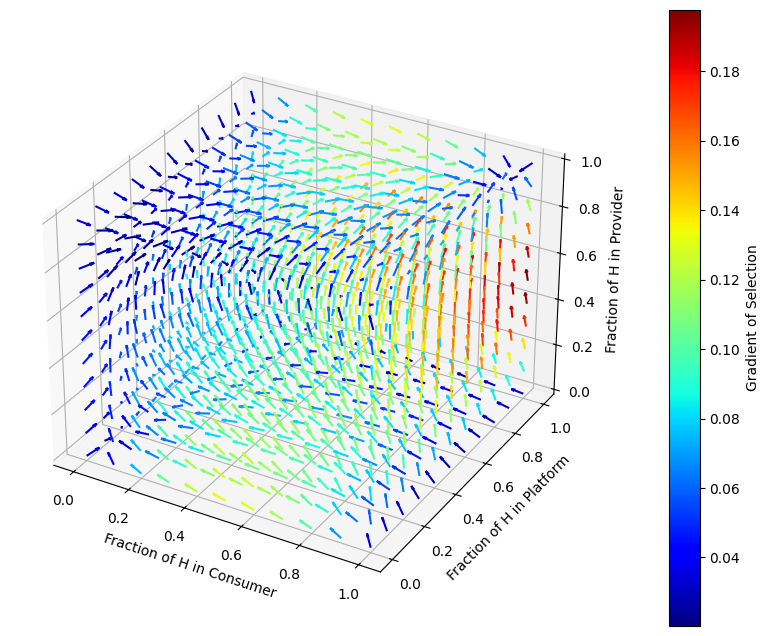

In [204]:
game.plot_gradient_of_selection(X, Y, Z, G1, G2, G3, players_names=players_names, fraction_name="H", legend="Gradient of Selection", threshold=0.00)

## Evolutionary Dynamics (Infinite Populations)

### Replicator Dynamics

In [66]:
strategies_counts = [[50, 0], [50, 0], [49, 1]]
game = EGT.Game(strategies_counts=strategies_counts, payoff_matrix=payoff_matrix, actions_names=actions_names, players_names=players_names)

dt = 0.01
steps = 10000
strategies_fractionss_hist, gradients = game.compute_iterative_replicator_dynamics(dt, steps)

#### Visualize Replicator Dynamics Strategies Evolution

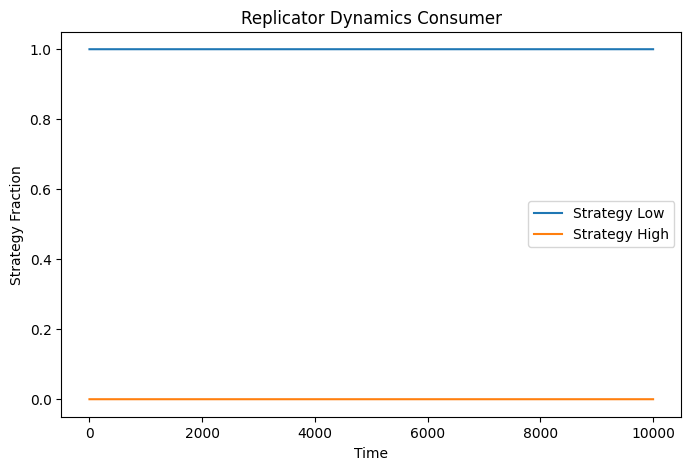

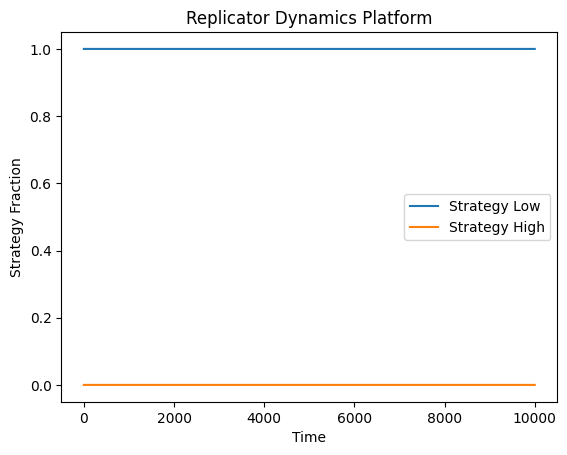

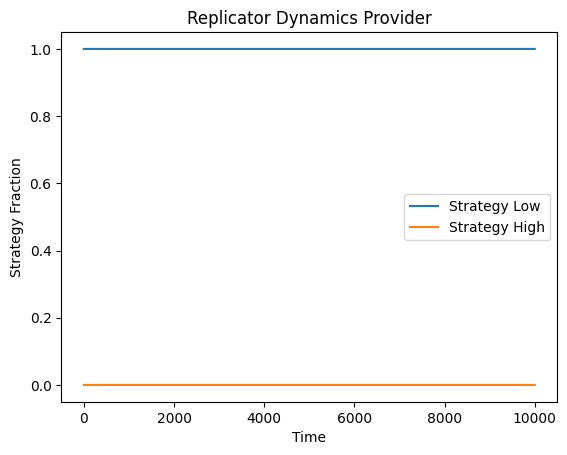

In [67]:
game.plot_replicator_dynamics_strategies_evol(strategies_fractionss_hist)